In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3b
commitnumber = f17e0b2
conc = 0.0008
dv = 0.001
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 257
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

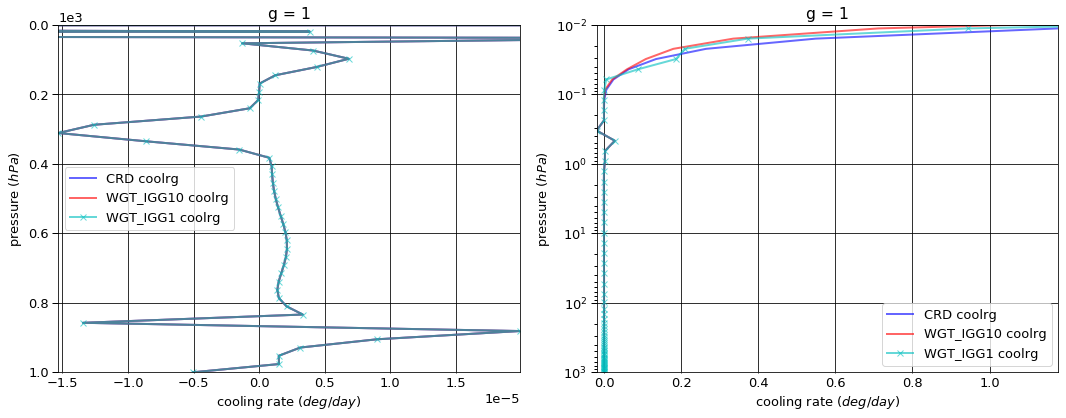

# Figure: cooling rate g-group 2

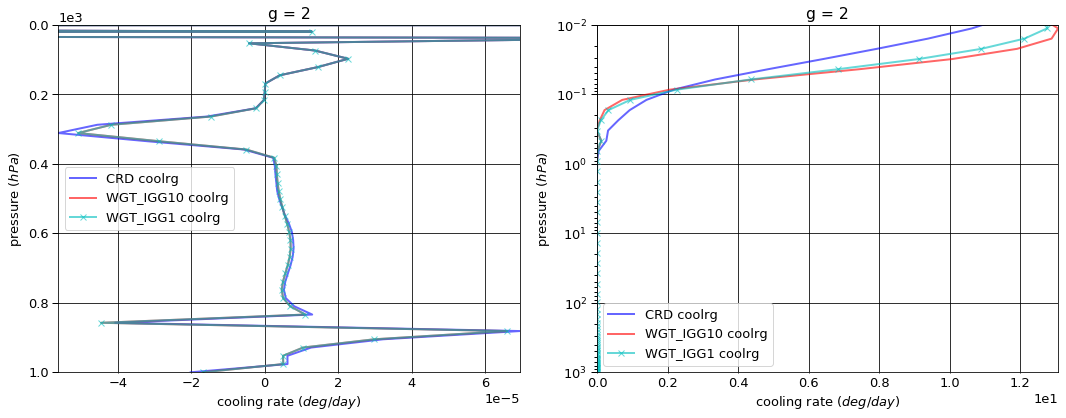

# Figure: cooling rate g-group 3

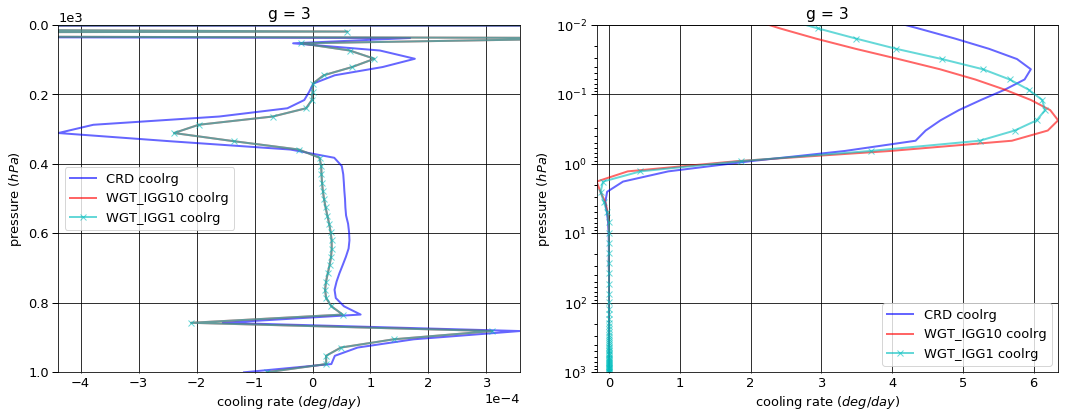

# Figure: cooling rate g-group 4

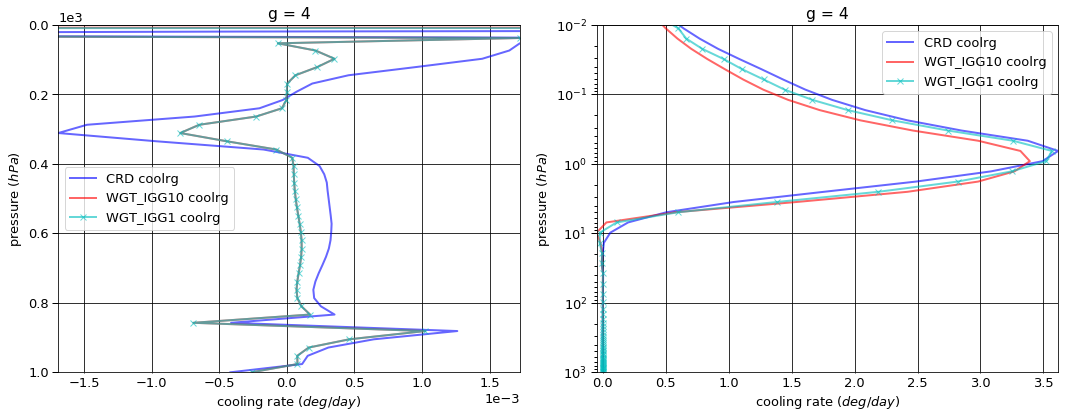

# Figure: cooling rate g-group 5

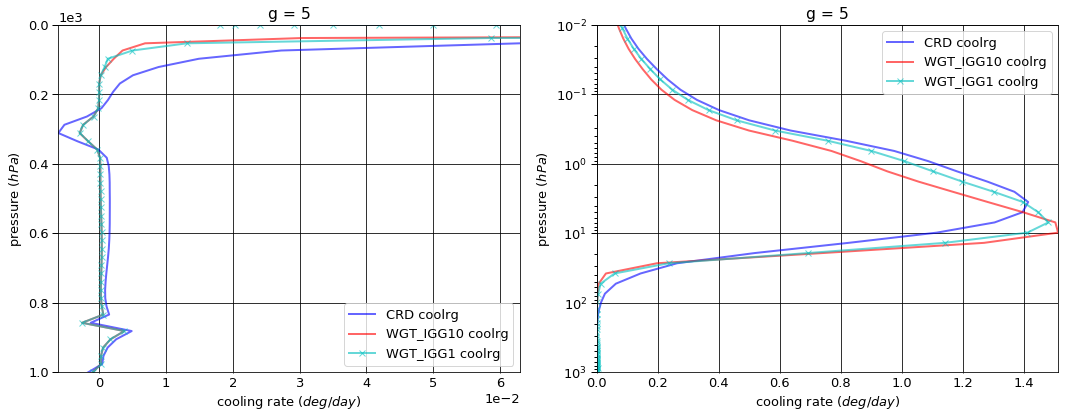

# Figure: cooling rate g-group 6

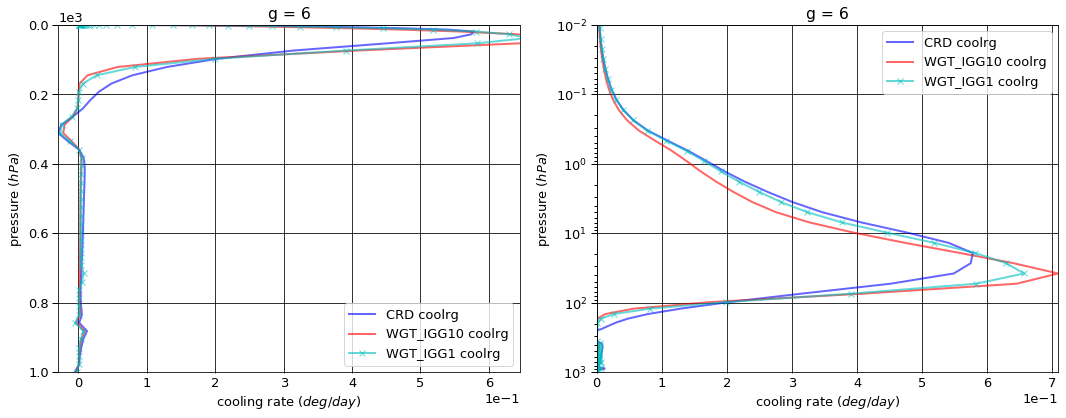

# Figure: cooling rate g-group 7

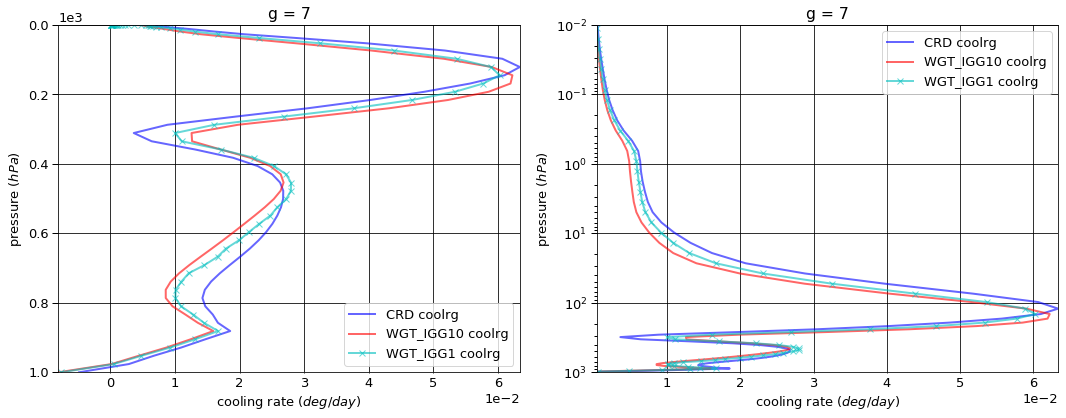

# Figure: cooling rate g-group total

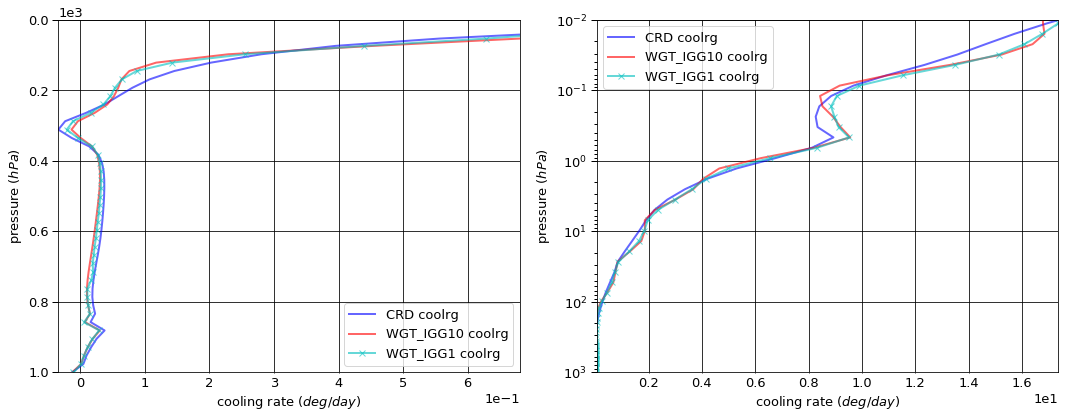

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.016775   0.000000 -0.016775
  1013.0   76     -0.034720   0.034737  0.000017
2 0.0      1      -0.088987   0.000000 -0.088987
  1013.0   76     -0.115359   0.115429  0.000070
3 0.0      1      -0.493934   0.000000 -0.493934
  1013.0   76     -0.541847   0.542275  0.000428
4 0.0      1      -1.238624   0.000000 -1.238624
  1013.0   76     -1.789812   1.791424  0.001612
5 0.0      1      -3.353058   0.000000 -3.353058
  1013.0   76     -6.592070   6.598358  0.006288
6 0.0      1      -6.113826   0.000000 -6.113826
  1013.0   76    -12.790834  12.812140  0.021305
7 0.0      1      -2.834819   0.000000 -2.834819
  1013.0   76     -5.172576   5.199187  0.026610


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.016978   0.000000 -0.016978
  1013.0   76     -0.034720   0.034737  0.000017
2 0.0      1      -0.085434   0.000000 -0.085434
  1013.0   76     -0.115359   0.115417  0.000057
3 0.0      1      -0.511846   0.000000 -0.511846
  1013.0   76     -0.541847   0.542116  0.000270
4 0.0      1      -1.270859   0.000000 -1.270859
  1013.0   76     -1.789812   1.790703  0.000891
5 0.0      1      -3.325335   0.000000 -3.325335
  1013.0   76     -6.592070   6.595354  0.003284
6 0.0      1      -6.032944   0.000000 -6.032944
  1013.0   76    -12.790834  12.801432  0.010598
7 0.0      1      -2.686887   0.000000 -2.686887
  1013.0   76     -5.172576   5.217011  0.044434


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.017099   0.000000 -0.017099
  1013.0   76     -0.034720   0.034737  0.000017
2 0.0      1      -0.085481   0.000000 -0.085481
  1013.0   76     -0.115359   0.115417  0.000057
3 0.0      1      -0.507207   0.000000 -0.507207
  1013.0   76     -0.541847   0.542116  0.000270
4 0.0      1      -1.271243   0.000000 -1.271243
  1013.0   76     -1.789812   1.790703  0.000891
5 0.0      1      -3.341676   0.000000 -3.341676
  1013.0   76     -6.592070   6.595354  0.003284
6 0.0      1      -6.052061   0.000000 -6.052061
  1013.0   76    -12.790834  12.797217  0.006383
7 0.0      1      -2.728390   0.000000 -2.728390
  1013.0   76     -5.172576   5.219708  0.047132


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000203  0.000000 -0.000203
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.003553  0.000000  0.003553
  1013.0   76     0.000000 -0.000012 -0.000012
3 0.0      1     -0.017912  0.000000 -0.017912
  1013.0   76     0.000000 -0.000159 -0.000159
4 0.0      1     -0.032235  0.000000 -0.032235
  1013.0   76     0.000000 -0.000720 -0.000720
5 0.0      1      0.027724  0.000000  0.027724
  1013.0   76     0.000000 -0.003004 -0.003004
6 0.0      1      0.080882  0.000000  0.080882
  1013.0   76     0.000000 -0.010708 -0.010707
7 0.0      1      0.147932  0.000000  0.147932
  1013.0   76     0.000000  0.017824  0.017824


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000324  0.000000 -0.000324
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.003506  0.000000  0.003506
  1013.0   76     0.000000 -0.000012 -0.000012
3 0.0      1     -0.013273  0.000000 -0.013273
  1013.0   76     0.000000 -0.000159 -0.000159
4 0.0      1     -0.032619  0.000000 -0.032619
  1013.0   76     0.000000 -0.000720 -0.000720
5 0.0      1      0.011382  0.000000  0.011382
  1013.0   76     0.000000 -0.003004 -0.003004
6 0.0      1      0.061765  0.000000  0.061765
  1013.0   76     0.000000 -0.014923 -0.014922
7 0.0      1      0.106429  0.000000  0.106429
  1013.0   76     0.000000  0.020521  0.020521

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      95.372974
  1001.112500 75     -0.000005
2 0.000312    1       7.713484
  1001.112500 75     -0.000020
3 0.000312    1       0.356619
  1001.112500 75     -0.000118
4 0.000312    1       0.053722
  1001.112500 75     -0.000418
5 0.000312    1       0.019943
  1001.112500 75     -0.001635
6 0.000312    1       0.000753
  1001.112500 75     -0.005482
7 0.000312    1       0.000082
  1001.112500 75     -0.004866


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      58.522036
  1001.112500 75     -0.000005
2 0.000312    1       3.204000
  1001.112500 75     -0.000017
3 0.000312    1      -0.278995
  1001.112500 75     -0.000079
4 0.000312    1       0.079335
  1001.112500 75     -0.000260
5 0.000312    1       0.016464
  1001.112500 75     -0.000957
6 0.000312    1       0.000638
  1001.112500 75     -0.003140
7 0.000312    1       0.000060
  1001.112500 75     -0.008077


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      61.143087
  1001.112500 75     -0.000005
2 0.000312    1       4.774055
  1001.112500 75     -0.000017
3 0.000312    1      -0.181261
  1001.112500 75     -0.000079
4 0.000312    1       0.066945
  1001.112500 75     -0.000260
5 0.000312    1       0.018020
  1001.112500 75     -0.000957
6 0.000312    1       0.000756
  1001.112500 75     -0.001860
7 0.000312    1       0.000073
  1001.112500 75     -0.007672


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.685094e+01
  1001.112500 75    -8.470329e-22
2 0.000312    1     -4.509484e+00
  1001.112500 75     3.449987e-06
3 0.000312    1     -6.356137e-01
  1001.112500 75     3.943505e-05
4 0.000312    1      2.561379e-02
  1001.112500 75     1.582326e-04
5 0.000312    1     -3.478847e-03
  1001.112500 75     6.780842e-04
6 0.000312    1     -1.143774e-04
  1001.112500 75     2.341795e-03
7 0.000312    1     -2.231403e-05
  1001.112500 75    -3.211338e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.422989e+01
  1001.112500 75    -8.470329e-22
2 0.000312    1     -2.939429e+00
  1001.112500 75     3.449987e-06
3 0.000312    1     -5.378799e-01
  1001.112500 75     3.943505e-05
4 0.000312    1      1.322337e-02
  1001.112500 75     1.582326e-04
5 0.000312    1     -1.922974e-03
  1001.112500 75     6.780842e-04
6 0.000312    1      2.938980e-06
  1001.112500 75     3.622171e-03
7 0.000312    1     -8.889923e-06
  1001.112500 75    -2.806805e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.140023,0.00000,-14.140023
1013.0,76,-27.037219,27.09355,0.056331



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-13.930283,0.000000,-13.930283
1013.0,76,-27.037219,27.096771,0.059552



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.003157,0.000000,-14.003157
1013.0,76,-27.037219,27.095254,0.058035



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.209741,0.000000,0.209741
1013.0,76,0.000000,0.003221,0.003221



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.136866,0.000000,0.136866
1013.0,76,0.000000,0.001703,0.001704


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,103.517576
1001.112500,75,-0.012544



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,61.543538
1001.112500,75,-0.012534



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,65.821675
1001.112500,75,-0.010849



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-41.974038
1001.112500,75,0.000010



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-37.695901
1001.112500,75,0.001695


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00128,0.001284
2,0.00425,0.004268
3,0.01996,0.020046
4,0.06595,0.066215
5,0.24303,0.243868
6,0.47273,0.473104
7,0.19280,0.191215


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.306538e-17
2,6.987267e-19
3,3.736738e-20
4,1.998379e-21
5,1.068718e-22
6,5.714218e-23
7,3.056582e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.306538e-17,NaN,0.00128,0.001284,0.00128,0.001284,1.0
2,6.987267e-19,0.053479,0.00425,0.004268,0.00553,0.005552,1.0
3,3.736738e-20,0.053479,0.01996,0.020046,0.02549,0.025598,1.0
4,1.998379e-21,0.053479,0.06595,0.066215,0.09144,0.091813,1.0
5,1.068718e-22,0.053479,0.24303,0.243868,0.33447,0.335681,1.0
6,5.714218e-23,0.534680,0.47273,0.473104,0.80720,0.808785,10.0
7,3.056582e-24,0.053491,0.19280,0.191215,1.00000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
